In [1]:
library(tidyverse) 
library(ggExtra)
library(ggthemes)
library(forecast)
library(ggfortify)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.4
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()
Warning message:
"package 'ggExtra' was built under R version 3.6.3"Warning message:
"package 'ggthemes' was built under R version 3.6.3"Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overw

# Contexte

In [2]:
uk <- read_table("../data.txt", col_types = "if")
period <- seq(as.Date('1969-01-01'), as.Date('1984-12-31'), by = "month")
uk_ts <- ts(uk$death, start = c(1969,1), frequency = 12)
uk_df <- bind_cols(uk, t = period)

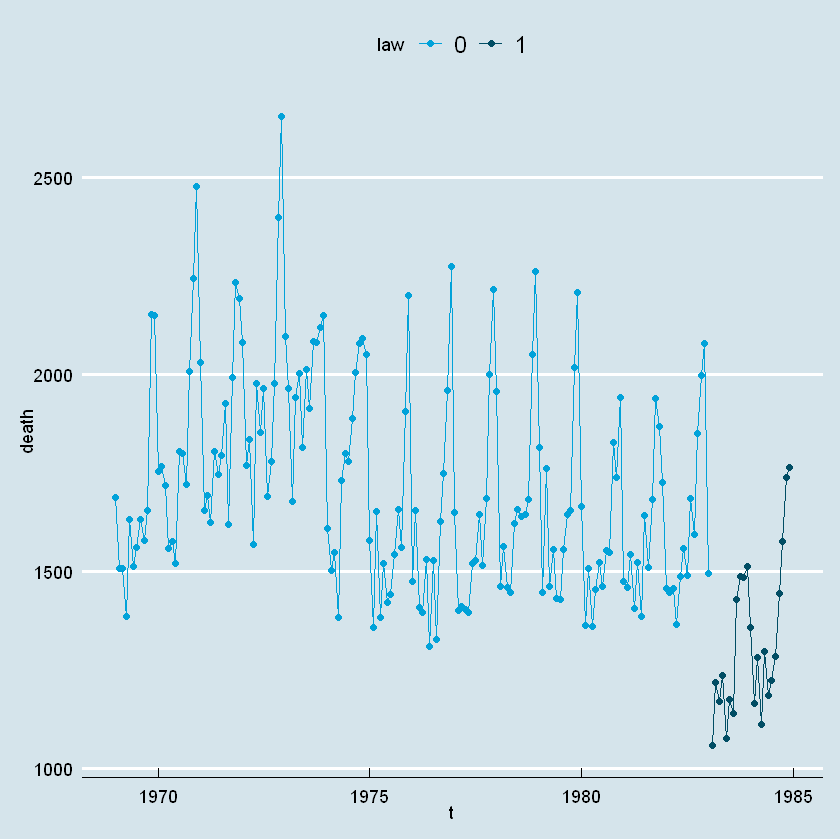

In [3]:
ggplot(uk_df) + aes(t, death, color = law) +
geom_line() + geom_point() +
theme_economist() + scale_color_economist()

\newpage

Ici, on cherche à démontrer que la périodicité est annuelle.  
On peut remarquer sur chaque "petite série temporelle mensuelle" la tendance qui décroit.

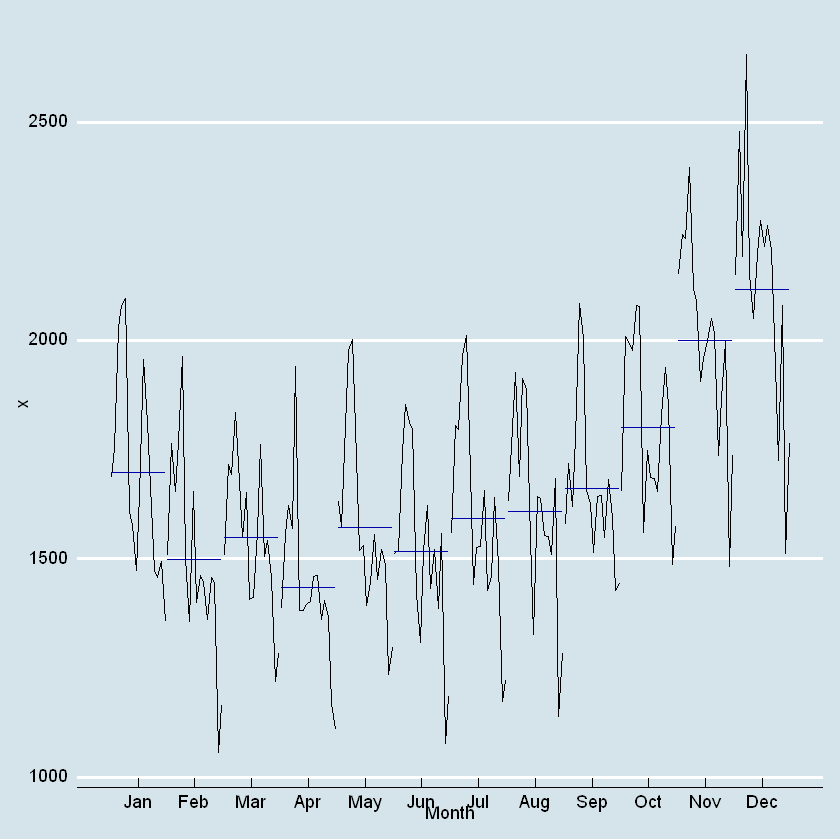

In [4]:
ggmonthplot(uk_ts) +
theme_economist() +
scale_color_economist()

# Modèle 1: Régression linéaire
On cherche un modèle paramétrique de la forme:

$$\text{death} = m_t + s_t + \epsilon_t$$

## 1. Régression sur la tendance
J'ai laissé le modèle "optimal" (*en bleu foncé*) sur chaque plot.  
Les modèles qu'on ajuste s'appelle "fit" (*en bleu clair*).

In [5]:
df_fit <- tibble(death = uk_df$death, t = 1:192) %>% 
mutate(t2 = t^2, t3 = t^3, t4 = t^4, t5 = t^5,
       t6 = t^6, t7 = t^7, t8 = t^8, t9 = t^9)

In [6]:
mod_fit <- lm(death ~ t + t2 + t3 + t4 + t8, data = df_fit)

J'ai essayé plusieurs modèles, j'ai essayé step aussi mais j'ai du réduire encore pour arriver à

$$m_t = 1349 + 46.5t - 1.17t^2 + \frac{t^3}{100} -3.432*10^{-5}t^4 + 2.613*10^{-15}t^8$$

On peut même enlever $t^4$ et $t^8$ puisque leur coefficient sont proches de $0$.


Call:
lm(formula = death ~ t + t2 + t3 + t4 + t8, data = df_fit)

Residuals:
    Min      1Q  Median      3Q     Max 
-391.81 -185.02  -44.44  118.54  763.27 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.349e+03  1.021e+02  13.215  < 2e-16 ***
t            4.650e+01  9.236e+00   5.035 1.12e-06 ***
t2          -1.171e+00  2.484e-01  -4.715 4.73e-06 ***
t3           1.076e-02  2.526e-03   4.260 3.25e-05 ***
t4          -3.432e-05  8.787e-06  -3.906 0.000131 ***
t8           2.613e-15  8.831e-16   2.958 0.003495 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 241.5 on 186 degrees of freedom
Multiple R-squared:  0.3228,	Adjusted R-squared:  0.3046 
F-statistic: 17.73 on 5 and 186 DF,  p-value: 2.367e-14


Warning message:
"attributes are not identical across measure variables;
they will be dropped"Warning message:
"Removed 12 row(s) containing missing values (geom_path)."Warning message:
"Removed 12 rows containing missing values (geom_point)."

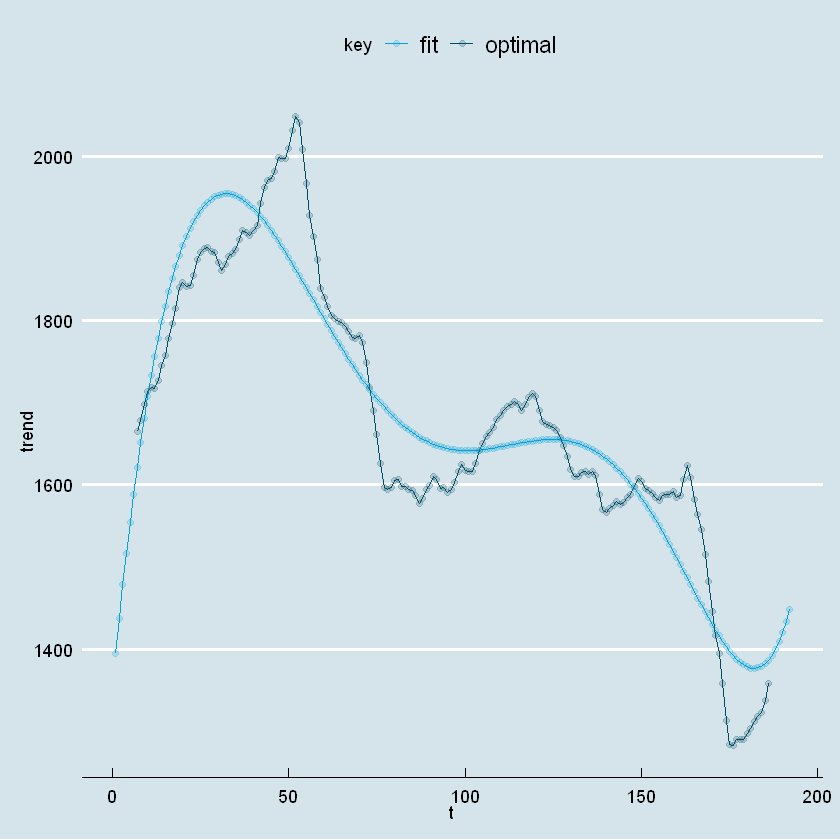

In [7]:
summary(mod_fit)
trend_fit <- mod_fit$fitted.values
tibble(optimal = ma(uk_ts, order = 12), fit = trend_fit, t = 1:192) %>% gather("key", "trend", -t) %>% 
ggplot() + aes(t, trend, color = key) + geom_line() + geom_point(alpha = 0.2) +
theme_economist() + scale_color_economist()

## 2. Régression sur la saisonalité
On part du même principe que les TP avec $cos(\frac{\pi k t}{6})$ et $sin(\frac{\pi k t}{6})$  
Dans le code, quand c'est `cos k` = $cos(\frac{\pi k t}{6})$, pareil pour `sin k`

In [8]:
season_fit <- (uk_ts - trend_fit)%>% 
matrix(12) %>% t() %>% 
colMeans(na.rm = T) %>% 
rep(length(uk_ts)/12)

sinusoides <- 1:192%o%c(rep(1:6,2)*pi/6)
sinusoides[,1:5] <- sin(sinusoides[,1:5])
sinusoides[,6:10] <- cos(sinusoides[,6:10])
sinusoides <- as_tibble(sinusoides)
names(sinusoides) <- c(paste0("sin",1:6),paste0("cos",1:6))

df_fit <- bind_cols(season = season_fit, t = 1:192, sinusoides)

Warning message:
"`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session."

In [9]:
mod_fit_season <- lm(season ~ sin1 + cos1 + cos2 + cos3, data = df_fit)

Donc après plusieurs essais qui vont dans tous les sens, on arrive à un modèle qui fit bien:

$$s_t = 199\,cos(\frac{\pi t}{6}) + 114\,cos(\frac{\pi t}{3}) + 57\,cos(\frac{\pi t}{2}) - 112\,sin(\frac{\pi t}{6})$$

On remarque d'ailleurs que ça fit nettement bien avec l'optimal.


Call:
lm(formula = season ~ sin1 + cos1 + cos2 + cos3, data = df_fit)

Residuals:
    Min      1Q  Median      3Q     Max 
-141.53  -43.24  -11.07   52.51  105.53 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.829e-14  4.968e+00    0.00        1    
sin1        -1.121e+02  7.026e+00  -15.96  < 2e-16 ***
cos1         1.985e+02  7.026e+00   28.25  < 2e-16 ***
cos2         1.140e+02  7.026e+00   16.22  < 2e-16 ***
cos3         5.698e+01  7.026e+00    8.11 6.51e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 68.85 on 187 degrees of freedom
Multiple R-squared:  0.8808,	Adjusted R-squared:  0.8782 
F-statistic: 345.4 on 4 and 187 DF,  p-value: < 2.2e-16


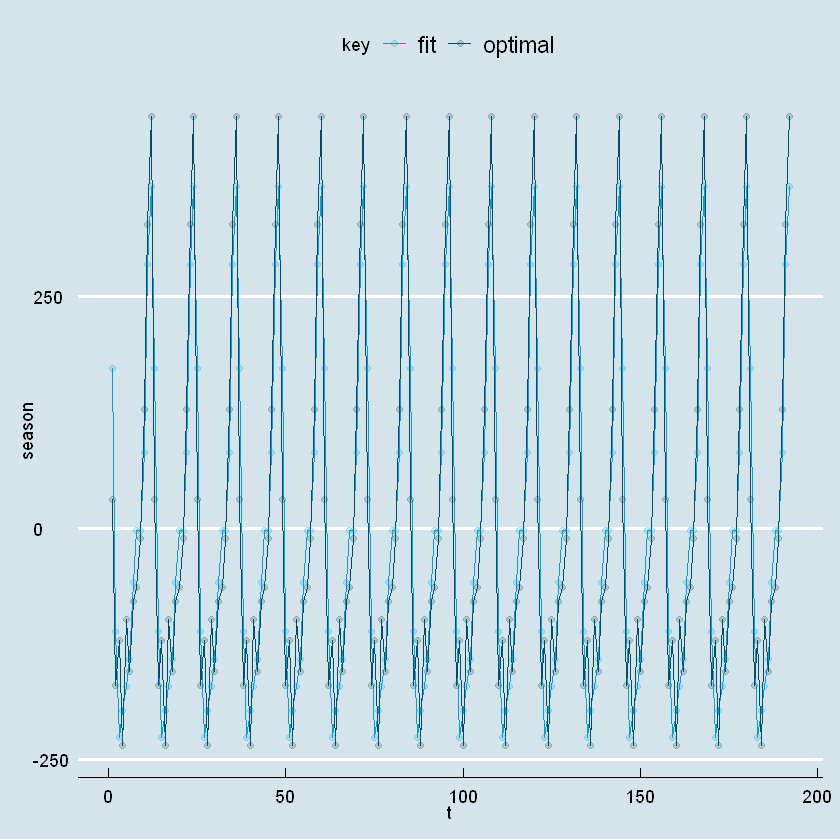

In [10]:
summary(mod_fit_season)

seasonal_fit <- mod_fit_season$fitted.values
tibble(optimal = season_fit, fit = seasonal_fit, t = 1:192) %>% gather("key", "season", -t) %>% 
ggplot() + aes(t, season, color = key) + geom_line() + geom_point(alpha = 0.2) +
theme_economist() + scale_color_economist()

\newpage

## 3. Résidus du modèle de régression
Comme c'est un modèle additif, il s'agit de la part non expliquée par la tendance et la saisonalité.

Ni l'ACF ni le PACF ne semblent décroitre du coup si on se base sur ce modèle ce sera ARMA ? ou ARIMA ?

In [11]:
residual_fit <- uk_ts - trend_fit - seasonal_fit

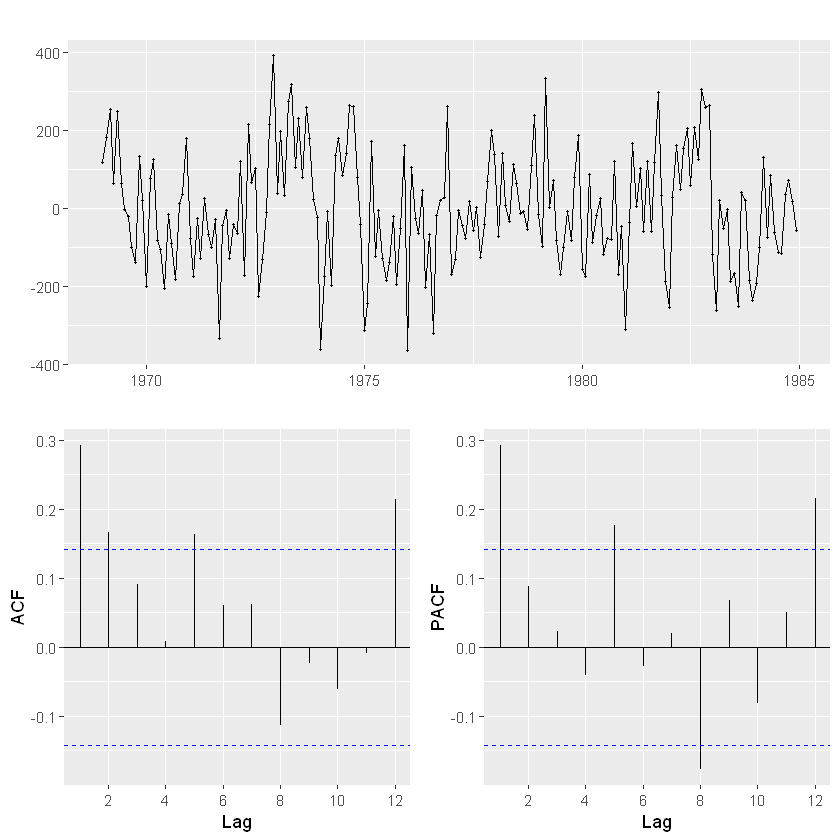

In [12]:
ggtsdisplay(residual_fit, lag.max = 12)

\newpage

In [13]:
shapiro.test(residual_fit)


	Shapiro-Wilk normality test

data:  residual_fit
W = 0.99425, p-value = 0.6684


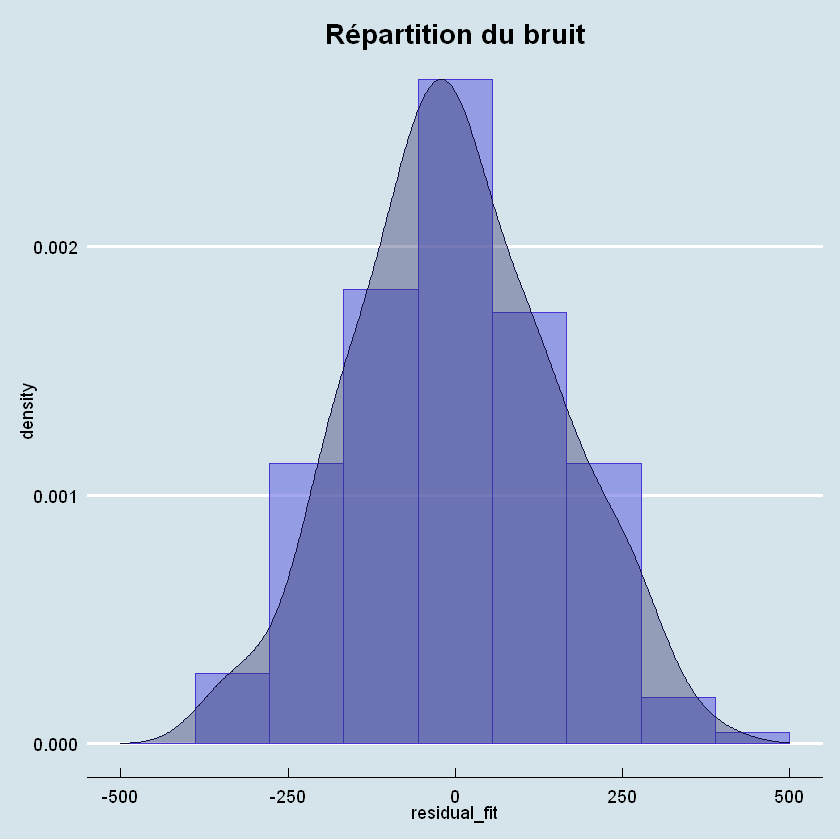

In [14]:
tibble(residual_fit) %>% 
ggplot() + aes(x = residual_fit) +
geom_histogram(aes(y=..density..), bins = 10, color = "#4834d4", fill = "#686de0", alpha = 0.6) + 
geom_density(color = "#130f40", fill = "#30336b", alpha = 0.4) +
labs(title = "Répartition du bruit") + xlim(c(-500, 500)) + theme_economist() +
theme(plot.title = element_text(hjust = 0.5))

Donc ça suit une loi normale, et on obtient:

$$\epsilon_t \sim \mathcal N(\mu = 0,\sigma^2 = 22 519)$$

\newpage

## 4. Décomposition
Donc on a un modèle paramétrique de la forme

$$\text{death} = m_t + s_t + \epsilon_t$$

$$\text{avec}\left\{
    \begin{array}{ll}
        m_t = 1349 + 46.5t - 1.17t^2 + \frac{t^3}{100} -3.432*10^{-5}t^4 + 2.613*10^{-15}t^8 \\
        s_t = 199\,cos(\frac{\pi t}{6}) + 114\,cos(\frac{\pi t}{3}) + 57\,cos(\frac{\pi t}{2}) - 112\,sin(\frac{\pi t}{6}) \\
        \epsilon_t \sim \mathcal N(0, 22\,519)
    \end{array}
\right.$$


Warning message:
"attributes are not identical across measure variables;
they will be dropped"

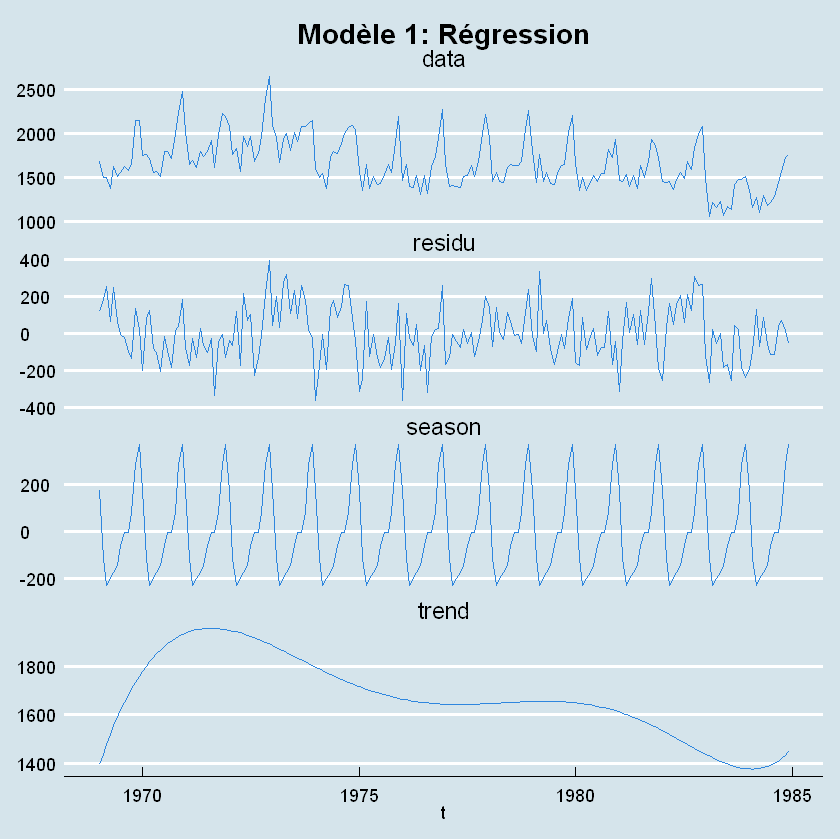

In [15]:
tibble(data = uk_ts, trend = trend_fit, season = seasonal_fit, residu = residual_fit, t = period) %>% 
gather("key", "value", -t) %>% ggplot() + aes(t, value) + geom_line(color = "#2e86de") + 
facet_wrap(.~key, ncol = 1, scales = "free_y") + theme_economist() + 
labs(y = NULL, title = "Modèle 1: Régression") + theme(plot.title = element_text(hjust = 0.5))

\newpage

# Modèle 2: Filtre linéaire

Alors le but ici c'est de ne pas passer par une régression linéaire mais plutôt par un filtre linéaire sur une moyenne mobile.  
On n'aura pas forcément un modèle paramétrique dans ce cas, bien qu'on peut estimer les paramètres.

## 1. Filtre sur la tendance
Comme on a dit qu'il s'agit de périodes de 12 mois, on va donc appliquer un filtre linéaire à notre série temporelle avec une moyenne mobile sur 12 périodes.  
J'ai pas mis la comparaison avec la tendance "optimale" puisque cette technique de filtre se superpose avec, du coup c'est l'optimale dans notre cas.

In [16]:
trend_filter <- stats::filter(
    uk_ts, rep(1/12, 12),
    method = "convolution",
    sides = 2
)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
"Removed 11 row(s) containing missing values (geom_path)."Warning message:
"Removed 11 rows containing missing values (geom_point)."

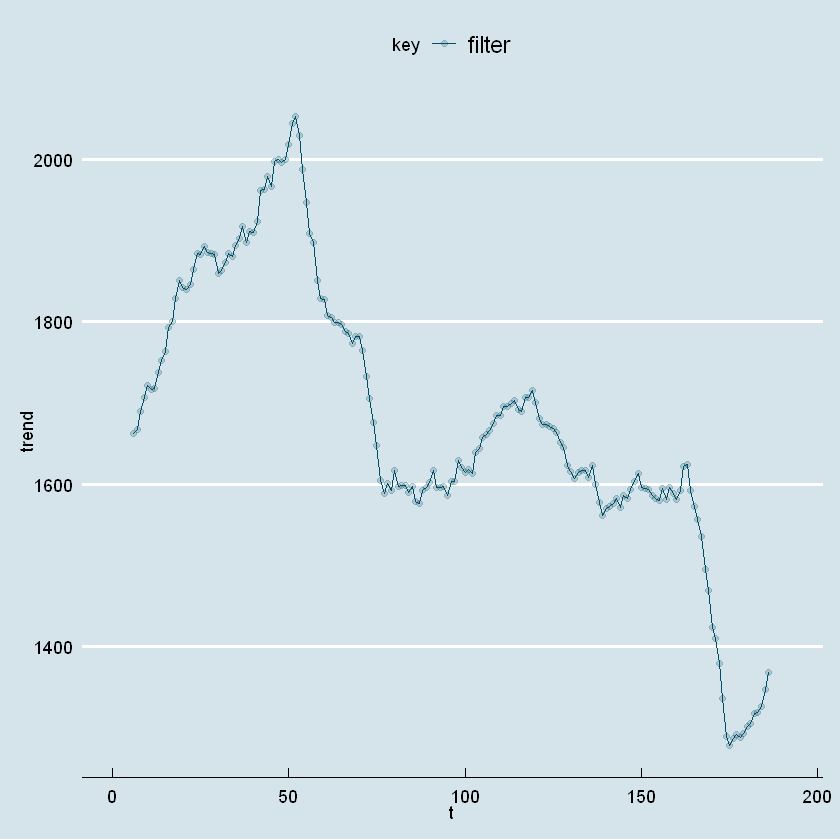

In [17]:
tibble(filter = trend_filter, t = 1:192) %>% gather("key", "trend", -t) %>% 
ggplot() + aes(t, trend, color = key) + geom_line() + geom_point(alpha = 0.2) +
theme_economist() + scale_color_economist()

\newpage

## 2. Filtre sur la saisonalité
L'idée ici est de calculer la saisonalité sur la série sans la tendance.  
Comme au tout début on a noté une périodicité annuelle, on déduira la saisonalité par la moyenne mensuelle.

In [18]:
seasonal_filter <- (uk_ts - trend_filter) %>% 
matrix(12) %>% t() %>% 
colMeans(na.rm = T) %>% 
rep(length(uk_ts)/12)

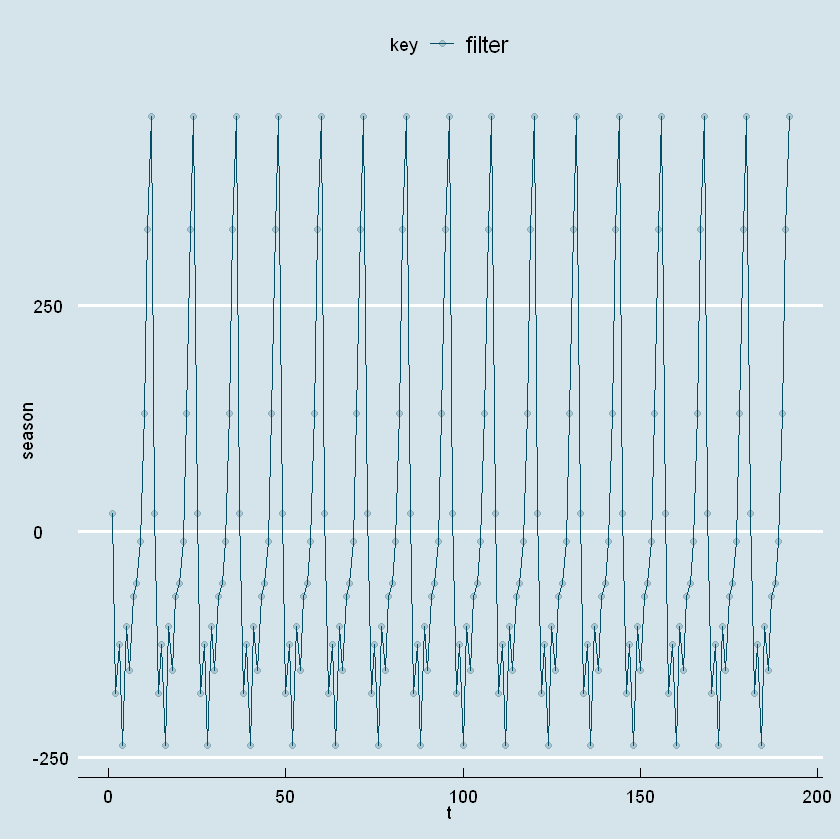

In [19]:
tibble(filter = seasonal_filter, t = 1:192) %>% gather("key", "season", -t) %>% 
ggplot() + aes(t, season, color = key) + geom_line() + geom_point(alpha = 0.2) +
theme_economist() + scale_color_economist()

On arrive quasiment à la saisonalité du *modèle 1 avec la Régression linéaire*, l'amplitude est juste plus grande sur ce modèle au mois de décembre.

\newpage

## 3. Filtre sur les résidus
Comme précédement, c'est un modèle additif donc let's go.

Là on a un ACF qui décroit, on part sur un MA avec un lag = $4$.

In [20]:
residual_filter <- uk_ts - trend_filter - seasonal_filter

Warning message:
"Removed 11 rows containing missing values (geom_point)."

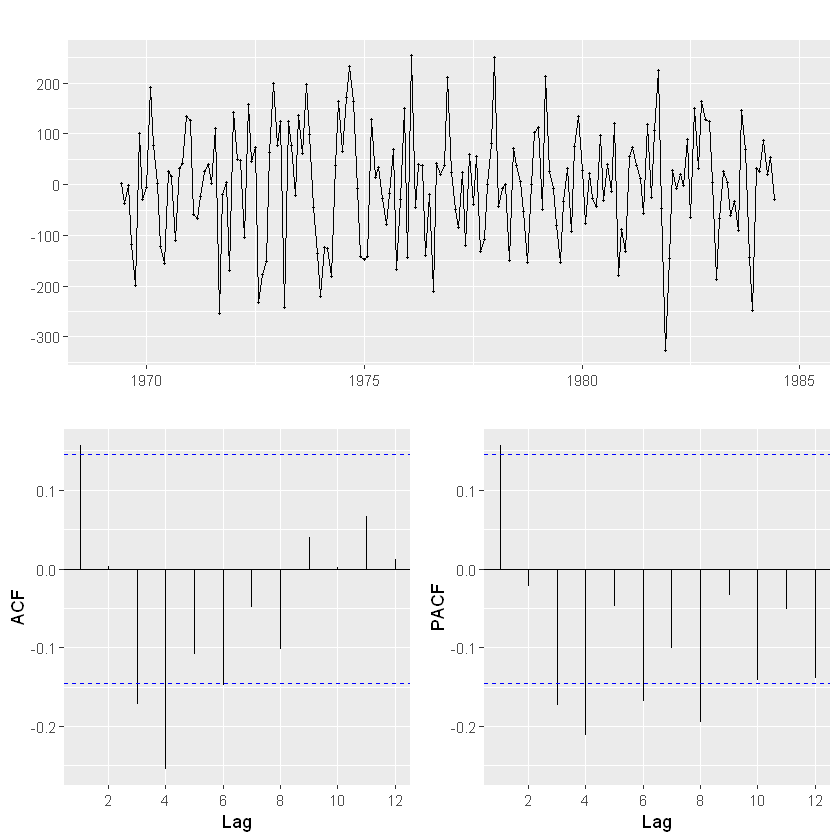

In [21]:
ggtsdisplay(residual_filter, lag.max = 12)

\newpage

In [22]:
shapiro.test(residual_filter)


	Shapiro-Wilk normality test

data:  residual_filter
W = 0.9913, p-value = 0.3456


Warning message:
"Removed 11 rows containing non-finite values (stat_bin)."Warning message:
"Removed 11 rows containing non-finite values (stat_density)."

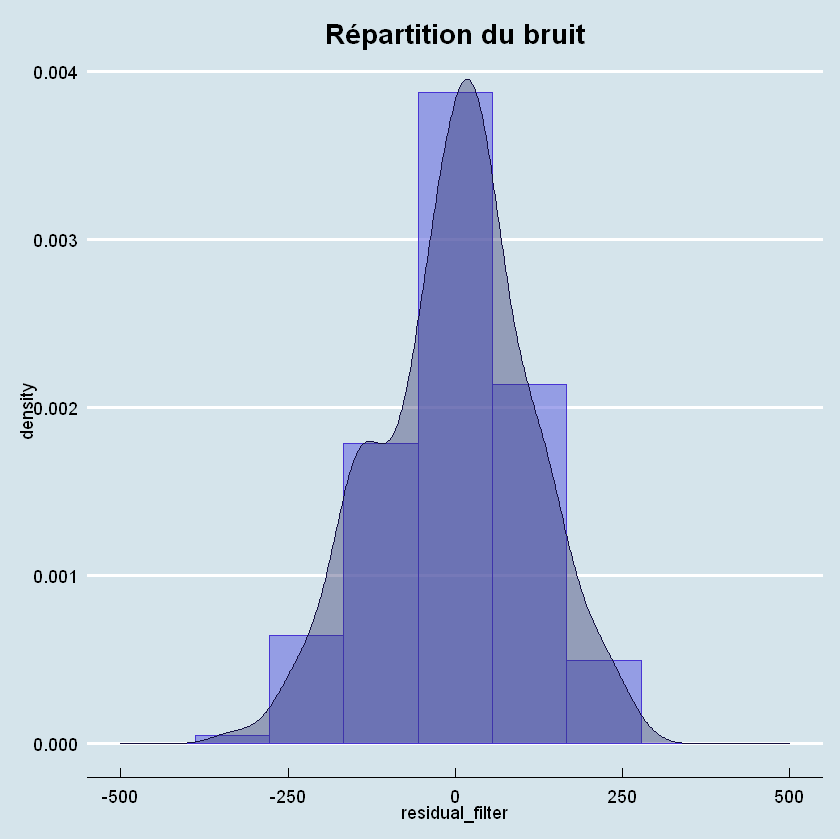

In [23]:
tibble(residual_filter) %>% 
ggplot() + aes(x = residual_filter) +
geom_histogram(aes(y=..density..), bins = 10, color = "#4834d4", fill = "#686de0", alpha = 0.6) + 
geom_density(color = "#130f40", fill = "#30336b", alpha = 0.4) +
labs(title = "Répartition du bruit") + xlim(c(-500, 500)) + theme_economist() +
theme(plot.title = element_text(hjust = 0.5))

Donc ça suit une loi normale, et on obtient:

$$\epsilon_t \sim \mathcal N(\mu = 0,\sigma^2 = 12\;446)$$

\newpage

## 4. Décomposition
Donc on a un modèle dont on connaît certains paramètres de la forme

$$\text{death} = m_t + s_t + \epsilon_t$$

$$\text{avec}\left\{
    \begin{array}{ll}
        s_t = \beta_0 + \beta_1\,cos(\frac{\pi t}{6}) + \beta_2\,cos(\frac{\pi t}{3}) + \beta_3\,cos(\frac{\pi t}{2}) - \beta_4\,sin(\frac{\pi t}{6}) + (\tau) \\
        \epsilon_t \sim \mathcal N(0, 12\,446)
    \end{array}
\right.$$


Warning message:
"attributes are not identical across measure variables;
they will be dropped"Warning message:
"Removed 6 row(s) containing missing values (geom_path)."

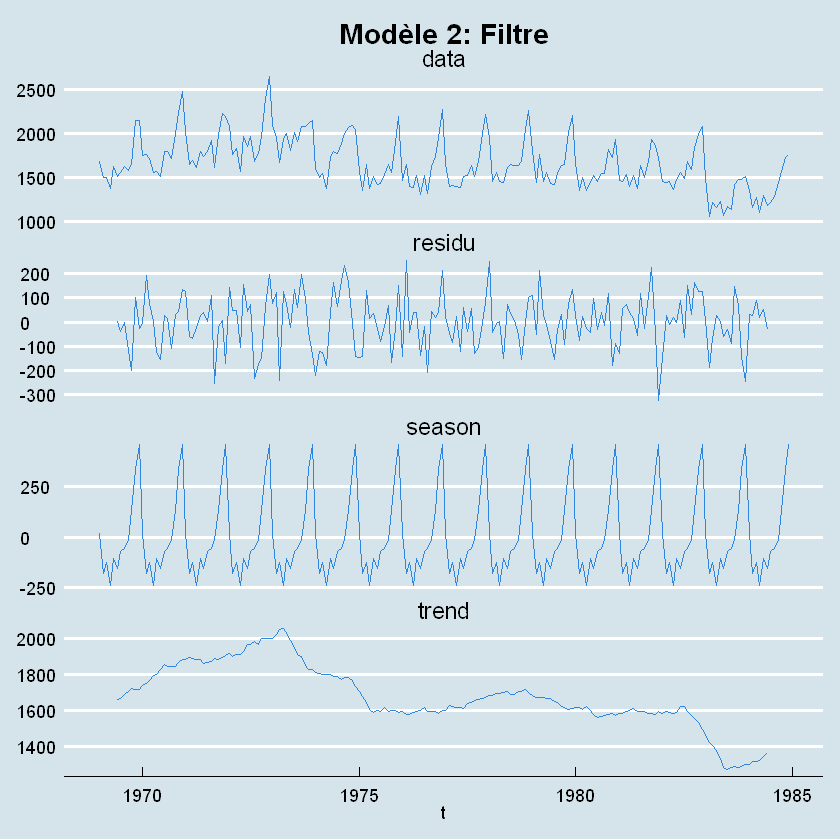

In [24]:
tibble(data = uk_ts, trend = trend_filter, season = seasonal_filter, residu = residual_filter, t = period) %>% 
gather("key", "value", -t) %>% ggplot() + aes(t, value) + geom_line(color = "#2e86de") + 
facet_wrap(.~key, ncol = 1, scales = "free_y") + theme_economist() + 
labs(y = NULL, title = "Modèle 2: Filtre") + theme(plot.title = element_text(hjust = 0.5))

\newpage

# Modèle 3: Décomposition automatique
C'est ce qu'on a fait dans le pdf que j'ai envoyé (*explorer.pdf*), du coup je ne vais pas la refaire ici.  
Il faut quand même noter que le modèle par filtre et la décomposition automatique donnent des résultats proches.

<br><hr><br>

**Remarque**:  
Les modèles 2 et 3 sont meilleurs que 1 puisque leurs résidus capturent moins de données. Ca voudrait donc dire qu'on a plus de contrôle sur le modèle et qu'il y a moins d'aléa.